In [1]:
import sys

sys.path.insert(1, '../')

from feature_extraction.variational_autoencoder.vae_feature_extractor import Vae_Feature_Extractor
from feature_prediction.long_short_term_memory.lstm_prediction_model import Lstm_prediction_model
from feature_prediction.deep_transformer.deep_transformer import Transformer_prediction_model
from arbitrage_free_ivs.nsa_ivs_dnn import NSA_IVS_DNN

import numpy as np

### Feature Extraction: Variational Autoencoder

In [2]:
# create and load data
test_id = 11
# id = 10:
# sabr_parameters = np.array([0.03, 0.4, -0.8, 1., 1.]) 
# noise = N(0,0.005)
# \alpha_i = 0.03 + 0.01 * np.sin(i/200), i=1,...600

# id = 11:
# sabr_parameters = np.array([0.03, 0.4, -0.8, 1., 1.]) 
# noise = N(0,0.005)
# \alpha_i = 0.03 + 0.015 * np.sin(i/200), i=1,...600
# \beta_i = 0.4 + 0.05 * np.sin(i/200), i=1,...600

feature_dim = 5

feature_extractor = Vae_Feature_Extractor(params={"feature_dim":feature_dim, "batch_size":600})
feature_extractor.set_data_from_file(f"../data/test{test_id}_data_sabr.csv", (600, 12, 16, 1))

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 12, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 12, 16, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 12, 16, 64)   256         conv_1[0][0]                     
__________________________________________________________________________________________________
lrelu_1 (LeakyReLU)             (None, 12, 16, 64)   0           bn_1[0][0]                       
____________________________________________________________________________________________

In [3]:
# train vae
history_vae = feature_extractor.train(500)
# save vae
feature_extractor.save_model(f"vae_{test_id}")

Epoch 1/500
1/1 [==============================] - 0s 2ms/step - loss: 1158.3661 - reconstruction_loss: 1153.7684 - kl_loss: 4.5976
Epoch 2/500
1/1 [==============================] - 0s 1ms/step - loss: 1143.5934 - reconstruction_loss: 1141.6898 - kl_loss: 1.9035
Epoch 3/500
1/1 [==============================] - 0s 1ms/step - loss: 1128.2166 - reconstruction_loss: 1126.6320 - kl_loss: 1.5846
Epoch 4/500
1/1 [==============================] - 0s 1ms/step - loss: 1102.7057 - reconstruction_loss: 1099.8912 - kl_loss: 2.8145
Epoch 5/500
1/1 [==============================] - 0s 1ms/step - loss: 1058.5586 - reconstruction_loss: 1052.5837 - kl_loss: 5.9748
Epoch 6/500
1/1 [==============================] - 0s 1ms/step - loss: 951.7194 - reconstruction_loss: 936.2973 - kl_loss: 15.4220
Epoch 7/500
1/1 [==============================] - 0s 1ms/step - loss: 724.2825 - reconstruction_loss: 672.4860 - kl_loss: 51.7965
Epoch 8/500
1/1 [==============================] - 0s 1ms/step - loss: 807.953

<Figure size 640x480 with 1 Axes>

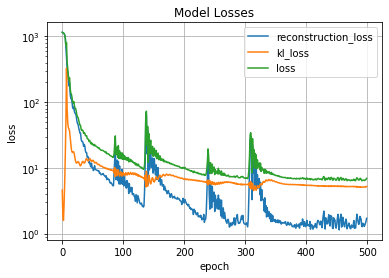

In [6]:
from matplotlib import pyplot as plt

plt.plot(history_vae.history['reconstruction_loss'])
plt.plot(history_vae.history['kl_loss'])
plt.plot(history_vae.history['loss'])

plt.title('Model Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['reconstruction_loss','kl_loss','loss'], loc='upper right')
plt.grid()
#plt.xscale("log")
plt.yscale("log")

plt.show()

In [3]:
# load vae
feature_extractor.load_model(f"vae_{test_id}")

In [4]:
data = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')

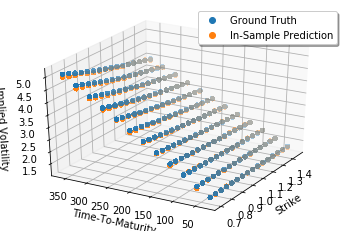

In [93]:
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

ind = 100

_, _, z = feature_extractor.enc.predict(data)
rec = feature_extractor.dec.predict(z)

strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

plot_data = {
    "iv_grid_1": data[ind:ind+1],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": rec[ind:ind+1],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth","In-Sample Prediction"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 0, view_angle=(30, 210))

Text(0.5, 0, 'Timestep')

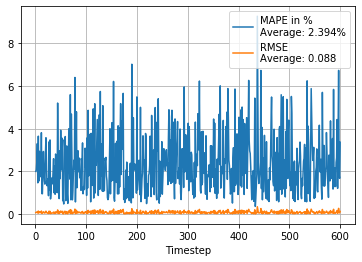

In [94]:
import matplotlib.pyplot as plt

true_ivs = data[:,:,:,0]
predicted_ivs = rec[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

reg = np.polyfit(x_, mape, 1)
#plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")

In [5]:
# load vae
feature_extractor.load_model(f"vae_{test_id}")

In [11]:
# save feature space data
data = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').reshape((600, 12, 16, 1)).astype('float32')
print("data shape:",data.shape)
feature_data = feature_extractor.produce_features(data)
print("feature data shape:",feature_data.shape)
feature_extractor.save_produced_features(f"latent_space_data/features_{test_id}")

data shape: (600, 12, 16, 1)
feature data shape: (600, 5)


### Feature Prediciton: Transformer

In [6]:
# load data and create data set with features
feature_data = np.genfromtxt(f"latent_space_data/features_{test_id}_vae_model", delimiter=',').astype('float32')
print(feature_data.shape)

look_back = 150
num_data_points = feature_data.shape[0]
num_train_data_points = int(0.7*num_data_points)

transformer_model = Transformer_prediction_model(feature_data, params={"look_back": look_back, "forecast_window": int(0.3*num_data_points)})

(600, 5)
Data shape with extra features:  (600, 9)


In [7]:
# train the model
path = f"./models/deep_transformer/res{test_id}/"
best_model = transformer_model.transformer(
    epochs=150, 
    path_to_save_model=path, 
    path_to_save_loss=path, 
    device="cpu"
)
print(best_model)

KeyboardInterrupt: 

In [43]:
# make predictions
prediction_features, in_sample_errors = transformer_model.inference(path_to_save_model="./models/deep_transformer/res/", best_model=best_model)
print(prediction_features.shape)

(180, 5)


(180, 5)


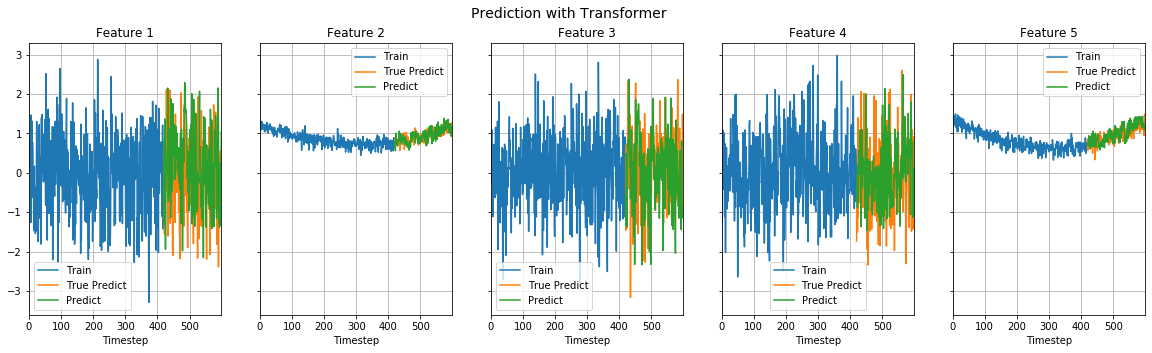

In [74]:
# plot
from feature_prediction.plot.plot_helper_functions import plot_features_with_prediction

true_ = feature_data[num_train_data_points:]

boot_strap_errors = in_sample_errors[np.random.randint(low=220, high=in_sample_errors.shape[0], size=true_.shape[0]),:]
print(boot_strap_errors.shape)
pred_vec = prediction_features+boot_strap_errors

fig = plot_features_with_prediction(
    data=feature_data[:num_train_data_points],
    prediction=pred_vec,
    true_predictions=true_,
    use_true_predictions=True,
    save_path_and_name=f"prediction_with_transformer_test{test_id}.pdf",
    params={
        "fig_title":"Prediction with Transformer",
        "share_y": True
    }
)

In [45]:
feature_extractor = Vae_Feature_Extractor(params={"feature_dim":feature_dim})
feature_extractor.load_model(f"vae_{test_id}")

In [46]:
predicted_iv_grids = feature_extractor.create_iv_grids_from_features(prediction_features)
print(predicted_iv_grids.shape)

(180, 12, 16, 1)


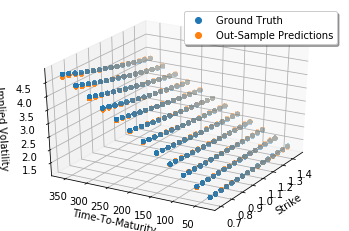

In [50]:
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)


plot_data = {
    "iv_grid_1": data[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "legend": ["Ground Truth", "Out-Sample Predictions"]
}

Plt = IV_Plotting_Helper(data=plot_data)

fig = Plt.plot_all_in_one(ind = 50, view_angle=(30, 210))

Text(0.5, 0, 'Timestep')

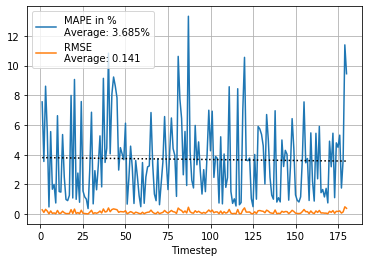

In [51]:
import matplotlib.pyplot as plt

true_ivs = data[600-180:,:,:,0]
predicted_ivs = predicted_iv_grids[:,:,:,0]

mape = np.mean(np.abs(true_ivs-predicted_ivs)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_ivs,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)


mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")

plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")

### IV Surface: No-Static-Arbitrage DNN

In [8]:
# create nsa_ivs_dnn
strikes = np.arange(0.7, 1.5, 0.05)
ttms = np.arange(30, 390, 30)

# same as data above but needs different shape
data_nsa_train = np.genfromtxt(f"../data/test{test_id}_data_sabr.csv", delimiter=',').astype('float32')
nsa_ivs = NSA_IVS_DNN(data_nsa_train, [strikes, ttms], (3,50,30,10))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                9750      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________


In [9]:
# train NSA DNN using training data
history = nsa_ivs.train(epochs=150)

# save NSA DNN
nsa_ivs.save_model(f"models/nsa_dnn_model{test_id}")

Epoch 1/150
60/60 [==============================] - 4s 72ms/step - total_loss: 190.0562 - reconstruction_loss: 189.7737 - nsa_C3: 0.0343 - nsa_C4: 0.0261 - nsa_C5: 0.2222 - nsa_C6: 0.0000e+00
Epoch 2/150
60/60 [==============================] - 4s 70ms/step - total_loss: 45.3112 - reconstruction_loss: 44.9619 - nsa_C3: 0.0420 - nsa_C4: 0.0340 - nsa_C5: 0.2733 - nsa_C6: 0.0000e+00
Epoch 3/150
60/60 [==============================] - 4s 65ms/step - total_loss: 28.2294 - reconstruction_loss: 27.8797 - nsa_C3: 0.0420 - nsa_C4: 0.0348 - nsa_C5: 0.2730 - nsa_C6: 0.0000e+00
Epoch 4/150
60/60 [==============================] - 4s 64ms/step - total_loss: 17.9733 - reconstruction_loss: 17.6278 - nsa_C3: 0.0412 - nsa_C4: 0.0359 - nsa_C5: 0.2683 - nsa_C6: 0.0000e+00
Epoch 5/150
60/60 [==============================] - 4s 64ms/step - total_loss: 12.0177 - reconstruction_loss: 11.6661 - nsa_C3: 0.0416 - nsa_C4: 0.0398 - nsa_C5: 0.2702 - nsa_C6: 0.0000e+00
Epoch 6/150
60/60 [========================

In [10]:
# load NSA DNN
nsa_ivs.load_model(f"models/nsa_dnn_model{test_id}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                9750      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________


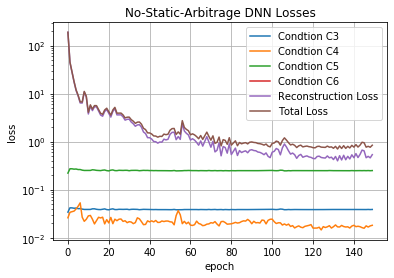

In [18]:
from matplotlib import pyplot as plt

plt.plot(history.history['nsa_C3'])
plt.plot(history.history['nsa_C4'])
plt.plot(history.history['nsa_C5'])
plt.plot(history.history['nsa_C6'])
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['total_loss'])
plt.title('No-Static-Arbitrage DNN Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Condtion C3','Condtion C4','Condtion C5','Condtion C6','Reconstruction Loss', 'Total Loss'], loc='upper right')
plt.grid()
plt.yscale("log")

#plt.show()
plt.savefig("nsa_dnn_losses.pdf")

In [54]:
# load NSA DNN
nsa_ivs.load_model(f"models/nsa_dnn_model{test_id}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                9750      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 11,601
Trainable params: 11,601
Non-trainable params: 0
_________________________________________________________________


In [55]:
#  create surfaces

strikes_test = np.arange(0.65, 1.55, 0.04)
ttms_test = np.arange(15, 415, 15)

in_sample_nsa_ivs = nsa_ivs.predict_all_surfaces(data_nsa_train, strikes_test, ttms_test)

In [57]:
# plot in sample
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

legend = ["NSA DNN Test Predictions", "Ground Truth"]

plot_data = {
    "iv_grid_1": data_nsa_train,
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs,
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "legend": legend
}

Plt_1 = IV_Plotting_Helper(data=plot_data)

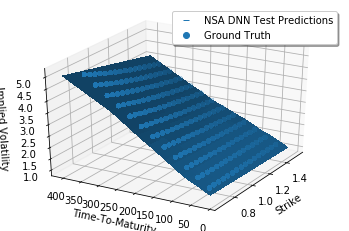

In [59]:
fig = Plt_1.plot_all_in_one(ind = 100, view_angle=(30, 210))

In [60]:
# plot all 
from arbitrage_free_ivs.plot_ivs import IV_Plotting_Helper

strikes = np.arange(0.7, 1.5, 0.05)
#ttms = np.arange(1, 13, 1)
ttms = np.arange(30, 390, 30)

nsa_ivs_for_predictions = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes_test, ttms_test)

legend = ["NSA IVS for Ground Truth", "NSA IVS for Prediction", "Ground Truth Grid", "Predicted Grid"]

plot_data = {
    "iv_grid_1": data_nsa_train[600-180:],
    "stikes_grid_1": strikes,
    "ttms_grid_1": ttms,
    "iv_surface_1": in_sample_nsa_ivs[600-180:],
    "stikes_surface_1": strikes_test,
    "ttms_surface_1": ttms_test,
    "iv_grid_2": predicted_iv_grids[:,:,:,0],
    "stikes_grid_2": strikes,
    "ttms_grid_2": ttms,
    "iv_surface_2": nsa_ivs_for_predictions,
    "stikes_surface_2": strikes_test,
    "ttms_surface_2": ttms_test,
    "legend": legend
}

Plt_2 = IV_Plotting_Helper(data=plot_data)

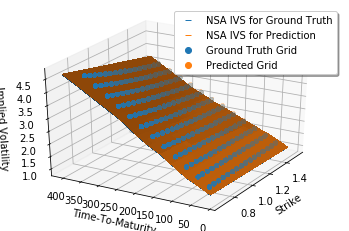

In [76]:
fig = Plt_2.plot_all_in_one(ind = 10, view_angle=(30, 210))

Text(0.5, 0, 'Timestep')

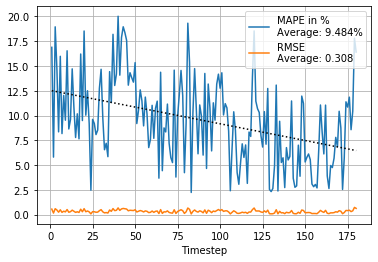

In [64]:
import matplotlib.pyplot as plt

true_ivs = data[600-180:,:,:,0]
predicted_iv_surfaces = nsa_ivs.predict_all_surfaces(predicted_iv_grids[:,:,:,0], strikes, ttms)

mape = np.mean(np.abs(true_ivs-predicted_iv_surfaces)/ true_ivs, axis=(1,2))*100
rmse = np.sqrt(np.mean(np.power(true_ivs-predicted_iv_surfaces,2), axis=(1,2)))

x_ = np.arange(1,mape.shape[0]+1)

mean_mape = np.round(np.mean(mape)*1e3)/1e3
mean_rmse = np.round(np.mean(rmse)*1e3)/1e3

plt.plot(x_, mape, label=f"MAPE in % \nAverage: {mean_mape}%")
plt.plot(x_, rmse, label=f"RMSE \nAverage: {mean_rmse}")
plt.grid()

reg = np.polyfit(x_, mape, 1)
plt.plot(x_, reg[0]*x_+reg[1],  c="black", ls=":")
plt.legend()
#plt.ylabel("MAPE in %")
plt.xlabel("Timestep")

In [87]:
noten = np.array([1.7,3,3,3.3,1,1,3.7,2,1.4,1.3,1.7,1.7,1.6,1,1,1,1.3,2.6,4,2.3,2.3,1.9,1.7,3,1.7])
credits = np.array([5,5,6,5,5,5,5,5,5,5,5,5,5,10,10,10,10,6,5,5,5,7,5,7,5])

average = np.sum(np.multiply(noten, credits))/np.sum(credits)

tmp_sum = np.sum(np.multiply(noten, credits))

# Für 1.84999
sum_1 = 1.84999 * 181
soll_1 = (sum_1 - tmp_sum)/30

# Für 1.79999
sum_2a = 1.79999 * 181
soll_2a = (sum_2a - tmp_sum)/30

# Für 1.74999
sum_2 = 1.74999 * 181
soll_2 = (sum_2 - tmp_sum)/30

print("Summe Credits: ", np.sum(credits))
print("Durchschnitt Aktuell: ", average)
print("Letze 30ECTS für 1.84999: ", soll_1)
print("Letze 30ECTS für 1.79999: ", soll_2a)
print("Letze 30ECTS für 1.74999: ", soll_2)

Summe Credits:  151
Durchschnitt Aktuell:  1.9066225165562913
Letze 30ECTS für 1.84999:  1.564939666666667
Letze 30ECTS für 1.79999:  1.263273
Letze 30ECTS für 1.74999:  0.9616063333333329
